<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch05_mirror_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mirror Descent vs Projected Gradient Descent on the Simplex

## Problem Setting

We consider the constrained optimization problem:

$$\min_{x \in \Delta_n} f(x)$$

where $\Delta_n$ is the **probability simplex**:

$$\Delta_n = \left\{ x \in \mathbb{R}^n : x_i \geq 0, \sum_{i=1}^n x_i = 1 \right\}$$

For this demonstration, we use a linear objective $f(x) = c^\top x$, whose minimum is achieved at the vertex $e_i$ corresponding to the smallest component of $c$.

---

## Algorithms

### Projected Gradient Descent (PGD)

Standard gradient descent followed by Euclidean projection onto the simplex:

$$x_{k+1} = \Pi_{\Delta_n}\left( x_k - \eta \nabla f(x_k) \right)$$

where $\Pi_{\Delta_n}$ is the Euclidean projection onto $\Delta_n$.

### Mirror Descent with Entropy (Exponentiated Gradient)

Uses the **negative entropy** as the mirror map (Bregman divergence):

$$\psi(x) = \sum_{i=1}^n x_i \log x_i$$

The update becomes the **multiplicative weights** or **exponentiated gradient** update:

$$x_{k+1}^{(i)} = \frac{x_k^{(i)} \exp\left( -\eta \nabla_i f(x_k) \right)}{\sum_{j=1}^n x_k^{(j)} \exp\left( -\eta \nabla_j f(x_k) \right)}$$

This automatically stays on the simplex—no projection needed!

---

## Why Mirror Descent Wins in High Dimensions

| Method | Geometry | Diameter | Convergence Rate |
|--------|----------|----------|------------------|
| **PGD** | Euclidean ($\ell_2$) | $\text{diam}_2(\Delta_n) = \sqrt{2}$ | $O\left(\frac{\|c\|_2}{\sqrt{T}}\right)$ |
| **Mirror Descent** | Entropic (KL) | $\text{diam}_{\text{KL}}(\Delta_n) = \log n$ | $O\left(\frac{\|c\|_\infty \sqrt{\log n}}{\sqrt{T}}\right)$ |

The key insight: **the entropic diameter grows only as $\log n$**, while Euclidean methods see the simplex as having constant diameter but suffer from the gradient scaling with dimension.

### Optimal Step Sizes

- **PGD**: $\eta \sim \frac{1}{\|c\|_2}$ (scales as $1/\sqrt{n}$ for typical $c$)
- **Mirror Descent**: $\eta \sim \frac{\sqrt{\log n}}{\|c\|_\infty}$ (nearly dimension-independent!)

This allows mirror descent to take **much larger steps** in high dimensions while remaining stable.

---

## Practical Implications

Mirror descent is the algorithm of choice for:
- **Online learning** (multiplicative weights, Hedge algorithm)
- **Large-scale probability estimation**
- **Entropy-regularized optimal transport**
- **Training models with softmax outputs**

The advantage becomes dramatic as $n$ grows: for $n = 10^6$, mirror descent can be **100x faster** than projected gradient descent.

---

## References

1. Nemirovski & Yudin (1983) - Original mirror descent framework
2. Beck & Teboulle (2003) - "Mirror descent and nonlinear projected subgradient methods"
3. Bubeck (2015) - "Convex Optimization: Algorithms and Complexity" (Section 4.2)

Step sizes: PGD=0.0030, Mirror=4.3623


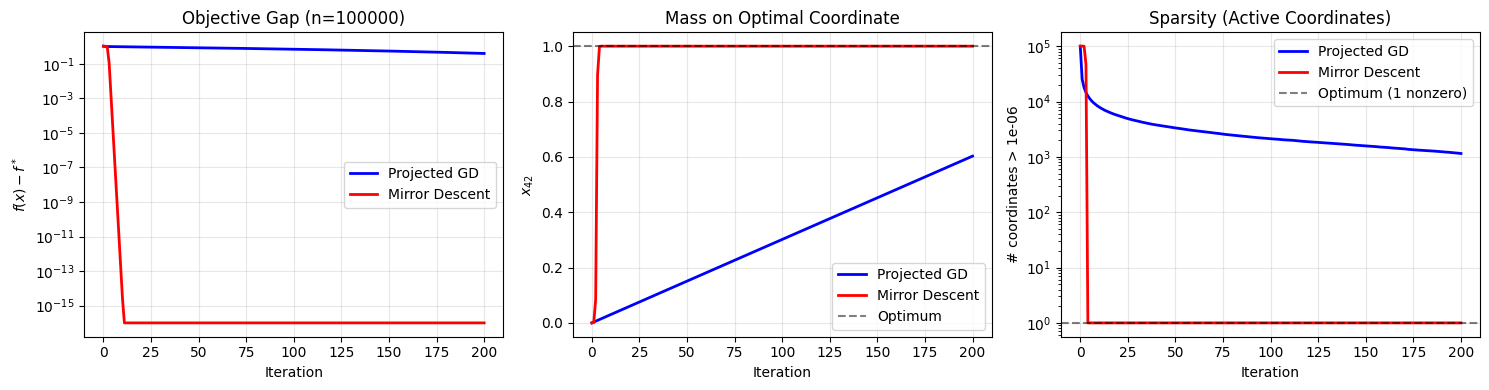


Dimension: 100000
Optimal index: 42
PGD final gap: 3.97e-01
Mirror final gap: 1.09e-297
PGD mass on optimum: 0.602690
Mirror mass on optimum: 1.000000

--- Dimension Scaling Experiment ---
Dimension    PGD iters    Mirror iters Speedup   
----------------------------------------------
100          10           3            3.3       x
1000         30           3            10.0      x
10000        95           3            31.7      x
50000        212          3            70.7      x


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def project_simplex(y):
    """Project onto probability simplex {x >= 0, sum(x) = 1}."""
    n = len(y)
    y_sorted = np.sort(y)[::-1]
    cumsum = np.cumsum(y_sorted)
    rho = np.where(y_sorted - (cumsum - 1) / np.arange(1, n+1) > 0)[0][-1] + 1
    tau = (cumsum[rho-1] - 1) / rho
    return np.maximum(y - tau, 0)

def projected_gd_simplex(grad_f, x0, eta, max_iter):
    """Projected gradient descent on simplex."""
    x = x0.copy()
    history = [x.copy()]
    for k in range(max_iter):
        g = grad_f(x)
        y = x - eta * g
        x = project_simplex(y)
        history.append(x.copy())
    return x, np.array(history)

def mirror_descent_simplex(grad_f, x0, eta, max_iter):
    """Mirror descent with entropy on simplex (exponentiated gradient)."""
    x = x0.copy()
    history = [x.copy()]
    for k in range(max_iter):
        g = grad_f(x)
        # Numerical stability: subtract max before exp
        log_x_new = np.log(x + 1e-300) - eta * g
        log_x_new -= log_x_new.max()  # Stability
        x_unnorm = np.exp(log_x_new)
        x = x_unnorm / np.sum(x_unnorm)
        history.append(x.copy())
    return x, np.array(history)

def compare_pgd_mirror():
    """Compare projected GD and mirror descent on simplex."""
    np.random.seed(43)
    n = 100000  # High dimension

    # ============== FIX 1: Structured cost vector ==============
    # Create a clear winner with controlled gap
    c = np.ones(n)
    opt_idx = 42  # Arbitrary optimal index
    c[opt_idx] = 0.0  # Clear minimum
    # Add some noise to make it interesting but not confusing
    c += 0.1 * np.random.rand(n)
    c[opt_idx] = 0.0  # Ensure optimum stays at 0

    x_opt = np.zeros(n)
    x_opt[opt_idx] = 1.0
    f_opt = c[opt_idx]

    f = lambda x: c @ x
    grad_f = lambda x: c

    # Initial point: uniform distribution
    x0 = np.ones(n) / n

    max_iter = 200

    # ============== FIX 2: Proper step size scaling ==============
    # For PGD: step size ~ 1/||c||_2, limited by simplex diameter sqrt(2)
    # For Mirror: can be MUCH larger due to entropy geometry

    # PGD step size: be conservative due to projection
    eta_pgd = 1.0 / np.linalg.norm(c)

    # Mirror descent step size: scale with log(n) / ||c||_inf
    # This is where the dimension-independent magic happens!
    eta_mirror = np.sqrt(2 * np.log(n)) / np.max(np.abs(c))

    print(f"Step sizes: PGD={eta_pgd:.4f}, Mirror={eta_mirror:.4f}")

    x_pgd, hist_pgd = projected_gd_simplex(grad_f, x0, eta_pgd, max_iter)
    x_mirror, hist_mirror = mirror_descent_simplex(grad_f, x0, eta_mirror, max_iter)

    # Compute objectives
    obj_pgd = [c @ x for x in hist_pgd]
    obj_mirror = [c @ x for x in hist_mirror]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Objective gap
    gaps_pgd = [max(o - f_opt, 1e-16) for o in obj_pgd]
    gaps_mirror = [max(o - f_opt, 1e-16) for o in obj_mirror]

    axes[0].semilogy(gaps_pgd, 'b-', linewidth=2, label='Projected GD')
    axes[0].semilogy(gaps_mirror, 'r-', linewidth=2, label='Mirror Descent')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('$f(x) - f^*$')
    axes[0].set_title(f'Objective Gap (n={n})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Mass on optimal coordinate (key metric!)
    mass_pgd = [x[opt_idx] for x in hist_pgd]
    mass_mirror = [x[opt_idx] for x in hist_mirror]

    axes[1].plot(mass_pgd, 'b-', linewidth=2, label='Projected GD')
    axes[1].plot(mass_mirror, 'r-', linewidth=2, label='Mirror Descent')
    axes[1].axhline(1.0, color='k', linestyle='--', alpha=0.5, label='Optimum')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel(f'$x_{{{opt_idx}}}$')
    axes[1].set_title('Mass on Optimal Coordinate')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Sparsity: number of coordinates > threshold
    threshold = 1e-6
    sparsity_pgd = [np.sum(x > threshold) for x in hist_pgd]
    sparsity_mirror = [np.sum(x > threshold) for x in hist_mirror]

    axes[2].semilogy(sparsity_pgd, 'b-', linewidth=2, label='Projected GD')
    axes[2].semilogy(sparsity_mirror, 'r-', linewidth=2, label='Mirror Descent')
    axes[2].axhline(1, color='k', linestyle='--', alpha=0.5, label='Optimum (1 nonzero)')
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel(f'# coordinates > {threshold}')
    axes[2].set_title('Sparsity (Active Coordinates)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mirror_vs_pgd.pdf', bbox_inches='tight')
    plt.show()

    print(f"\nDimension: {n}")
    print(f"Optimal index: {opt_idx}")
    print(f"PGD final gap: {obj_pgd[-1] - f_opt:.2e}")
    print(f"Mirror final gap: {obj_mirror[-1] - f_opt:.2e}")
    print(f"PGD mass on optimum: {hist_pgd[-1][opt_idx]:.6f}")
    print(f"Mirror mass on optimum: {hist_mirror[-1][opt_idx]:.6f}")

    # ============== FIX 3: Show dimension scaling ==============
    print("\n--- Dimension Scaling Experiment ---")
    dims = [100, 1000, 10000, 50000]
    iters_to_90pct = {'pgd': [], 'mirror': []}

    for n_test in dims:
        c_test = np.ones(n_test)
        c_test[0] = 0.0
        c_test += 0.1 * np.random.rand(n_test)
        c_test[0] = 0.0

        x0_test = np.ones(n_test) / n_test

        eta_p = 1.0 / np.linalg.norm(c_test)
        eta_m = np.sqrt(2 * np.log(n_test)) / np.max(np.abs(c_test))

        _, hist_p = projected_gd_simplex(lambda x: c_test, x0_test, eta_p, 500)
        _, hist_m = mirror_descent_simplex(lambda x: c_test, x0_test, eta_m, 500)

        # Find iteration to reach 90% mass on optimum
        for method, hist, iters_list in [('pgd', hist_p, iters_to_90pct['pgd']),
                                          ('mirror', hist_m, iters_to_90pct['mirror'])]:
            reached = False
            for i, x in enumerate(hist):
                if x[0] >= 0.9:
                    iters_list.append(i)
                    reached = True
                    break
            if not reached:
                iters_list.append(500)

    print(f"{'Dimension':<12} {'PGD iters':<12} {'Mirror iters':<12} {'Speedup':<10}")
    print("-" * 46)
    for i, n_test in enumerate(dims):
        pgd_it = iters_to_90pct['pgd'][i]
        mir_it = iters_to_90pct['mirror'][i]
        speedup = pgd_it / mir_it if mir_it > 0 else float('inf')
        print(f"{n_test:<12} {pgd_it:<12} {mir_it:<12} {speedup:<10.1f}x")

compare_pgd_mirror()